In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

In [2]:
data_path = "/kaggle/input/lish-moa/"

In [3]:
train_features_data = pd.read_csv(data_path+'train_features.csv')
test_features_data = pd.read_csv(data_path+'test_features.csv')
train_target_scored = pd.read_csv(data_path+'train_targets_scored.csv')

train_feat_targets_data = pd.merge(train_features_data, train_target_scored, on='sig_id', how='left')

In [4]:
cp_type_mapping = {'trt_cp':0, 'ctl_vehicle':1}
cp_dose_mapping = {'D1':0, 'D2':1}

train_feat_targets_data['cp_type'] = train_feat_targets_data['cp_type'].map(cp_type_mapping)
train_feat_targets_data['cp_dose'] = train_feat_targets_data['cp_dose'].map(cp_dose_mapping)

test_features_data['cp_type'] = test_features_data['cp_type'].map(cp_type_mapping)
test_features_data['cp_dose'] = test_features_data['cp_dose'].map(cp_dose_mapping)


training_features = [col for col in train_features_data.columns if col!='sig_id']
target_labels = [col for col in train_target_scored.columns if col!='sig_id']

In [5]:
gene_expression_ls = [col for col in train_features_data.columns if 'g-' in col]
cell_viability_ls = [col for col in train_features_data.columns if 'c-' in col]

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
train_features_data_2d = tsne.fit_transform(train_features_data[gene_expression_ls].T.values)

In [7]:
from numpy import *
import sys  # maxint

def minBoundingRect(hull_points_2d):
    #print "Input convex hull points: "
    #print hull_points_2d

    # Compute edges (x2-x1,y2-y1)
    edges = zeros( (len(hull_points_2d)-1,2) ) # empty 2 column array
    for i in range( len(edges) ):
        edge_x = hull_points_2d[i+1,0] - hull_points_2d[i,0]
        edge_y = hull_points_2d[i+1,1] - hull_points_2d[i,1]
        edges[i] = [edge_x,edge_y]
    #print "Edges: \n", edges

    # Calculate edge angles   atan2(y/x)
    edge_angles = zeros( (len(edges)) ) # empty 1 column array
    for i in range( len(edge_angles) ):
        edge_angles[i] = math.atan2( edges[i,1], edges[i,0] )
    #print "Edge angles: \n", edge_angles

    # Check for angles in 1st quadrant
    for i in range( len(edge_angles) ):
        edge_angles[i] = abs( edge_angles[i] % (math.pi/2) ) # want strictly positive answers
    #print "Edge angles in 1st Quadrant: \n", edge_angles

    # Remove duplicate angles
    edge_angles = unique(edge_angles)
    #print "Unique edge angles: \n", edge_angles

    # Test each angle to find bounding box with smallest area
    min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0, 0) # rot_angle, area, width, height, min_x, max_x, min_y, max_y
    print ("Testing", len(edge_angles), "possible rotations for bounding box... \n")
    for i in range( len(edge_angles) ):

        # Create rotation matrix to shift points to baseline
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = array([ [ math.cos(edge_angles[i]), math.cos(edge_angles[i]-(math.pi/2)) ], [ math.cos(edge_angles[i]+(math.pi/2)), math.cos(edge_angles[i]) ] ])
        #print "Rotation matrix for ", edge_angles[i], " is \n", R

        # Apply this rotation to convex hull points
        rot_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
        #print "Rotated hull points are \n", rot_points

        # Find min/max x,y points
        min_x = nanmin(rot_points[0], axis=0)
        max_x = nanmax(rot_points[0], axis=0)
        min_y = nanmin(rot_points[1], axis=0)
        max_y = nanmax(rot_points[1], axis=0)
        #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

        # Calculate height/width/area of this bounding rectangle
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        #print "Potential bounding box ", i, ":  width: ", width, " height: ", height, "  area: ", area 

        # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
        if (area < min_bbox[1]):
            min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )
        # Bypass, return the last found rect
        #min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )

    # Re-create rotation matrix for smallest rect
    angle = min_bbox[0]   
    R = array([ [ math.cos(angle), math.cos(angle-(math.pi/2)) ], [ math.cos(angle+(math.pi/2)), math.cos(angle) ] ])
    #print "Projection matrix: \n", R

    # Project convex hull points onto rotated frame
    proj_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
    #print "Project hull points are \n", proj_points

    # min/max x,y points are against baseline
    min_x = min_bbox[4]
    max_x = min_bbox[5]
    min_y = min_bbox[6]
    max_y = min_bbox[7]
    #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_point = dot( [ center_x, center_y ], R )
    #print "Bounding box center point: \n", center_point

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (4,2) ) # empty 2 column array
    corner_points[0] = dot( [ max_x, min_y ], R )
    corner_points[1] = dot( [ min_x, min_y ], R )
    corner_points[2] = dot( [ min_x, max_y ], R )
    corner_points[3] = dot( [ max_x, max_y ], R )
    #print "Bounding box corner points: \n", corner_points

    #print "Angle of rotation: ", angle, "rad  ", angle * (180/math.pi), "deg"

    return (angle, min_bbox[1], min_bbox[2], min_bbox[3], center_point, corner_points) 

In [8]:
angle, min_bbox1, min_bbox2, min_bbox3, center_point, corner_points = minBoundingRect(train_features_data_2d)

Testing 771 possible rotations for bounding box... 



In [9]:
corner_points

array([[ 18.88779636, -19.49096775],
       [ -5.86625477, -25.32952621],
       [-17.36358401,  23.41632053],
       [  7.39046712,  29.25487899]])

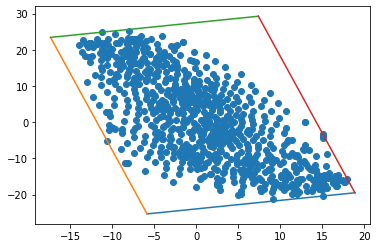

In [10]:
import matplotlib.pyplot as plt
plt.scatter(train_features_data_2d[:, 0], train_features_data_2d[:, 1])
plt.plot(corner_points[0:2, 0], corner_points[0:2, 1])
plt.plot(corner_points[1:3, 0], corner_points[1:3, 1])
plt.plot(corner_points[2:4, 0], corner_points[2:4, 1])
plt.plot([corner_points[3, 0], corner_points[0, 0]], [corner_points[3, 1], corner_points[0, 1]])

In [11]:
import math
rotation_matrix = np.array([[math.cos(angle), -math.sin(angle)],
                          [math.sin(angle), math.cos(angle)]])
train_features_data_2d_rotated = np.matmul(train_features_data_2d, rotation_matrix)
corner_points_rotated = np.matmul(corner_points, rotation_matrix)

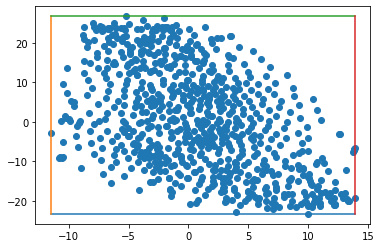

In [12]:
plt.scatter(train_features_data_2d_rotated[:, 0], train_features_data_2d_rotated[:, 1])
plt.plot(corner_points_rotated[0:2, 0], corner_points_rotated[0:2, 1])
plt.plot(corner_points_rotated[1:3, 0], corner_points_rotated[1:3, 1])
plt.plot(corner_points_rotated[2:4, 0], corner_points_rotated[2:4, 1])
plt.plot([corner_points_rotated[3, 0], corner_points_rotated[0, 0]], [corner_points_rotated[3, 1], corner_points_rotated[0, 1]])

In [13]:
img_size=32
def rescale_cartersian_cords(arr):
    arr_x = arr[:, 0].reshape((arr.shape[0], 1))
    arr_y = arr[:, 1].reshape((arr.shape[0], 1))
    new_arr_x = ((arr_x - arr_x.min()) * (1/(arr_x.max() - arr_x.min()) * img_size)).astype('uint8')
    new_arr_y = ((arr_y - arr_y.min()) * (1/(arr_y.max() - arr_y.min()) * img_size)).astype('uint8')
    rescaled_arr = np.concatenate((new_arr_x, new_arr_y), axis=1)
    return rescaled_arr

train_features_data_2d_rescaled = rescale_cartersian_cords(train_features_data_2d_rotated)

In [14]:
def map_feature_values(rescaled_arr, feature_values_array):
    pixel_value_arr = np.zeros((img_size, img_size))
    for i, value in enumerate(feature_values_array):
        pixel_x_cord = rescaled_arr[i][0]
        pixel_y_cord = rescaled_arr[i][1]
        
        pixel_value_arr[pixel_x_cord-1][pixel_y_cord-1] = value
    # arr_trans = ((pixel_value_arr - pixel_value_arr.min()) * (1/(pixel_value_arr.max() - pixel_value_arr.min()) * 255)).astype('uint8')
    return pixel_value_arr

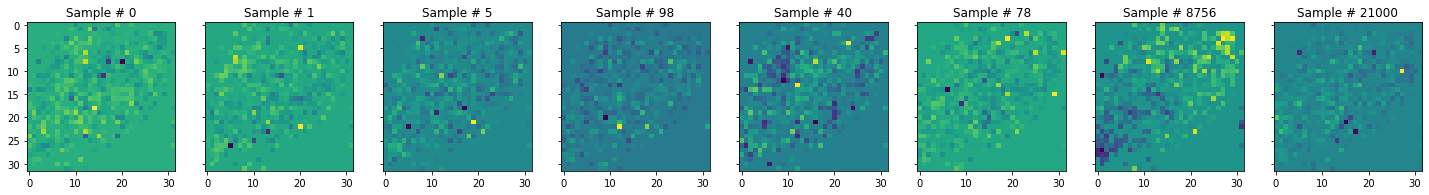

In [15]:
sample_num = [0, 1, 5, 98, 40, 78, 8756, 21000]
pixel_matrix_ls = []
for num in sample_num:
    pixel_value_arr = map_feature_values(train_features_data_2d_rescaled, train_features_data[gene_expression_ls].values[num])
    pixel_matrix_ls.append(pixel_value_arr)

fig, axes = plt.subplots(nrows=1, ncols=len(sample_num), figsize=(25, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    plt.imshow(pixel_matrix_ls[i])
    plt.gca().set_title('Sample # {}'.format(sample_num[i]))
plt.show()

In [16]:
import matplotlib
from tqdm.notebook import tqdm
import cv2
try:
    os.makedirs('images/gene_seq_images', exist_ok=True)
except:
    pass

geneseq_image_data = []
for sig_id, feature_value in tqdm(zip(train_features_data['sig_id'].values, 
                                      train_features_data[gene_expression_ls].values),
                                      total=len(train_features_data)):
    
    pixel_value_arr = map_feature_values(train_features_data_2d_rescaled, feature_value)
    
    geneseq_image_data.append(pixel_value_arr.reshape((1, img_size, img_size)))
    # cv2.imwrite('images/gene_seq_images/{}.png'.format(sig_id), pixel_value_arr.reshape((img_size, img_size, 1)))
# !zip -r images.zip images/gene_seq_images

In [17]:
test_geneseq_image_data = []
for sig_id, feature_value in tqdm(zip(test_features_data['sig_id'].values, 
                                      test_features_data[gene_expression_ls].values),
                                      total=len(test_features_data)):
    
    pixel_value_arr_test = map_feature_values(train_features_data_2d_rescaled, feature_value)
    
    test_geneseq_image_data.append(pixel_value_arr_test.reshape((1, img_size, img_size)))

In [18]:
train_feat_targets_data['image_data'] = geneseq_image_data
test_features_data['image_data'] = test_geneseq_image_data

In [19]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
class TrainData(Dataset):
    def __init__(self, train_features_data, image_data_colname, target_labels):
        self.feat = train_features_data[image_data_colname].values
        self.labels = train_features_data[target_labels].values
        
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.feat[idx])
        target_labels = torch.FloatTensor(self.labels[idx])
        return img, target_labels

    def __len__(self):
        return len(self.feat)
    

class TestData(Dataset):
    def __init__(self, data, image_data_colname):
        self.feat = data[image_data_colname].values
        
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.feat[idx])
        return img

    def __len__(self):
        return len(self.feat)

In [20]:
# train_data = TrainData(train_feat_targets_data, 'image_data', target_labels)
# trainloader = DataLoader(train_data, batch_size=32)

In [21]:
num_input_features = 3+772+100
num_output_features = 206
batch_size = 256
num_epochs = 20

class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # img_size=16x16
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)), # img_size=8x8
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),# img_size=4x4,
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),# img_size=4x4      
        )
        self.fc_layer = nn.Sequential(
            
            nn.Linear(in_features=2048, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=num_output_features)  
        
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*4*4)
        x  = self.fc_layer(x)
        return x

In [22]:
def evaluate(model, validloader, criterion):
    final_loss = 0
    valid_preds = []
    for i, data in enumerate(validloader):
        features, labels = data
        outputs = model(features)
        loss = criterion(outputs.float(), labels.float())
        final_loss+=loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
    
    final_loss /= len(validloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def train(model, trainloader, criterion, optimizer):
    running_loss = 0
    for i, data in enumerate(trainloader):
        features, labels = data
        optimizer.zero_grad()
        outputs = model(features)
        #loss
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

    training_loss = running_loss/len(trainloader)
    return training_loss, model

def test_prediction(model, testloader):
    preds_df = pd.DataFrame()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            features = data
            outputs = model(features)
            temp_df = pd.DataFrame(F.sigmoid(outputs).numpy())
            preds_df = pd.concat([preds_df, temp_df])
    return preds_df

In [23]:
final_preds_arr = np.zeros((len(test_features_data), len(target_labels)))
kfold = MultilabelStratifiedKFold(n_splits=5, random_state=1008, shuffle=True)

for n, (train_idx, valid_idx) in enumerate(kfold.split(train_feat_targets_data, train_feat_targets_data[target_labels])):
    print ('-'*5)
    print ('Fold {}'.format(n+1))
    print ('-'*5)
    
    # network
    nn_model = cnn_model().float()

    ## loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(params=nn_model.parameters(), lr=0.001)
    
    # splitting into train and validation
    train_data_fold, valid_data_fold = train_feat_targets_data.loc[train_idx], train_feat_targets_data.loc[valid_idx]
    
    # trainloader
    train_data =  TrainData(train_data_fold, 'image_data', target_labels)
    trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    # validloader
    valid_data = TrainData(valid_data_fold, 'image_data', target_labels)
    validloader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
    
    # testloader
    test_data = TestData(test_features_data, 'image_data')
    testloader = DataLoader(dataset=test_data, batch_size=batch_size)
        
    for epoch in range(num_epochs):
        training_loss, nn_model = train(nn_model, trainloader, criterion, optimizer)
        valid_loss, valid_preds = evaluate(nn_model, validloader, criterion)
        print ('\t', 'Epoch {}, Training Loss = {}, Valid Loss = {}'.format(epoch, training_loss, valid_loss))
        
    preds_df = test_prediction(nn_model, testloader).values
    final_preds_arr+=preds_df
final_preds_arr = final_preds_arr/5

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1008 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


-----
Fold 1
-----
	 Epoch 0, Training Loss = 0.08468406942983468, Valid Loss = 0.020965600288227984
	 Epoch 1, Training Loss = 0.02028774658838908, Valid Loss = 0.0197834958763499
	 Epoch 2, Training Loss = 0.019611540387074154, Valid Loss = 0.019379473438388424
	 Epoch 3, Training Loss = 0.019268544266621272, Valid Loss = 0.019219667111572466
	 Epoch 4, Training Loss = 0.01900453880429268, Valid Loss = 0.018790781203853458
	 Epoch 5, Training Loss = 0.018737877458333968, Valid Loss = 0.018617157383184684
	 Epoch 6, Training Loss = 0.018465960423151653, Valid Loss = 0.01842379883715981
	 Epoch 7, Training Loss = 0.0182393079996109, Valid Loss = 0.018258710244768543
	 Epoch 8, Training Loss = 0.018138987695177397, Valid Loss = 0.018179398079059626
	 Epoch 9, Training Loss = 0.017950974330306055, Valid Loss = 0.018143790332894576
	 Epoch 10, Training Loss = 0.017871089167892932, Valid Loss = 0.018011184115158885
	 Epoch 11, Training Loss = 0.017713661131759484, Valid Loss = 0.0178859171

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----
Fold 2
-----
	 Epoch 0, Training Loss = 0.08287458126743634, Valid Loss = 0.02100038459818614
	 Epoch 1, Training Loss = 0.020166664520899456, Valid Loss = 0.01993792798174055
	 Epoch 2, Training Loss = 0.01957507515947024, Valid Loss = 0.019573115498611803
	 Epoch 3, Training Loss = 0.019198101237416266, Valid Loss = 0.019183930989943053
	 Epoch 4, Training Loss = 0.01891679920256138, Valid Loss = 0.019033554941415787
	 Epoch 5, Training Loss = 0.01866774241129557, Valid Loss = 0.01874206499441674
	 Epoch 6, Training Loss = 0.018437472184499103, Valid Loss = 0.018654557141034228
	 Epoch 7, Training Loss = 0.018266425194839637, Valid Loss = 0.01845154264255574
	 Epoch 8, Training Loss = 0.018054472332199416, Valid Loss = 0.018389606064087467
	 Epoch 9, Training Loss = 0.01792434458931287, Valid Loss = 0.01825373178642047
	 Epoch 10, Training Loss = 0.01779431525617838, Valid Loss = 0.01820736545089044
	 Epoch 11, Training Loss = 0.017611939509709677, Valid Loss = 0.01803303024682

In [24]:
final_pred_df = pd.DataFrame(final_preds_arr)
final_pred_df.columns = target_labels
sample_submission = pd.read_csv(data_path+'sample_submission.csv')
final_pred_df = pd.concat([sample_submission[['sig_id']], final_pred_df.reset_index(drop=True)], axis=1)
final_pred_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.002506,0.002366,0.002373,0.020366,0.023341,0.006427,0.003652,0.007920,0.000945,...,0.000477,0.001553,0.004070,0.007031,0.003616,0.000957,0.004790,0.001877,0.002506,0.001975
1,id_001897cda,0.000155,0.000334,0.001153,0.001884,0.001624,0.001446,0.001394,0.003722,0.001324,...,0.000209,0.000845,0.000891,0.001165,0.017507,0.000173,0.049642,0.000518,0.005427,0.001025
2,id_002429b5b,0.000326,0.000296,0.001215,0.013458,0.009557,0.001556,0.002398,0.002483,0.000391,...,0.000425,0.000373,0.001322,0.000776,0.003496,0.000136,0.004818,0.001816,0.001877,0.000721
3,id_00276f245,0.000222,0.000310,0.001105,0.009262,0.004157,0.002257,0.002056,0.003533,0.000819,...,0.000360,0.001617,0.001701,0.016640,0.005833,0.000226,0.016012,0.001049,0.002954,0.001302
4,id_0027f1083,0.001185,0.000760,0.001058,0.010495,0.017100,0.003340,0.002717,0.002870,0.000231,...,0.000243,0.000320,0.001765,0.000704,0.001626,0.000294,0.003112,0.001161,0.000808,0.000551


In [25]:
controlled_samples = test_features_data[test_features_data['cp_type']==1]['sig_id'].tolist()
final_pred_df.loc[final_pred_df['sig_id'].isin(controlled_samples), target_labels] = 0

In [26]:
final_pred_df.to_csv('submission.csv', index=False)